# Extracting reusable filters from Diffusion models for controlled image manipulation

In [1]:
%%capture
!pip install diffusers transformers torch accelerate numpy pillow accelerate

In [2]:
import torch
import numpy as np
from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
import matplotlib.pyplot as plt

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Matplotlib is building the font cache; this may take a moment.


# Load the pretrained Stable Diffusion model and CLIP model

In [3]:

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
pipe = pipe.to("cuda")



model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

# Create functions to 

- get text embeddings from a prompt 
- to generate latents from a text embeddings
- apply difference matrix to latents
- decode latent embeddings back into an image

In [183]:


def get_text_embedding(pipe, prompts):
    # Tokenize the prompts and get the text embeddings
    batch_size = len(prompts) if isinstance(prompts, list) else 1
    # Tokenize with padding and truncation to ensure consistent length
    text_inputs = pipe.tokenizer(prompts, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt").input_ids
    
    # Get text embeddings for the inputs
    text_embeddings = pipe.text_encoder(text_inputs.to("cuda"))[0]

    # Get unconditioned embeddings (used as conditioning in some generation processes)
    uncond_input = pipe.tokenizer([""] * batch_size, padding="max_length", max_length=text_inputs.shape[-1], return_tensors="pt")
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to("cuda"))[0]

    # Concatenate the unconditional embeddings and the text embeddings
    full_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    return full_embeddings


@torch.no_grad()
def get_latents_from_embedding(text_embedding, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    # Set up the initial latents
    latents = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        generator=None,
        device=pipe.device,
        dtype=text_embedding.dtype
    )
    latents = latents * pipe.scheduler.init_noise_sigma

    # Set up the scheduler
    pipe.scheduler.set_timesteps(num_inference_steps)

    # Denoising loop
    for t in pipe.scheduler.timesteps:
        # expand the latents if we are doing classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embedding).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    return latents



def apply_difference_matrix_to_latents(latents, diff_matrix, weight):
    # Blend the difference matrix and apply to latents
    return  latents + weight * diff_matrix


def decode_latent_to_image(pipe, latent_embedding):
    # Decode the latent into a tensor
    latent_embedding = 1 / 0.18215 * latent_embedding
    with torch.no_grad():
        decoded_image_tensor = pipe.vae.decode(latent_embedding).sample  # Decodes the latent tensor

    image = (decoded_image_tensor / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image


def create_difference_matrix(text_embedding_1, text_embedding_2):
    return text_embedding_2 - text_embedding_1




# Get the text embeddings for two prompts (representing two different concepts)


In [ ]:

prompt_2 = "butterfly in van gogh's starry night painting style"
prompt_1 = "butterfly"

text_embedding_1 = get_text_embedding(pipe, [prompt_1])
text_embedding_2 = get_text_embedding(pipe, [prompt_2])


In [126]:
len(text_embedding_1), len(text_embedding_2)

(2, 2)

# Generate the latents from the both prompts

In [184]:


latent1 = get_latents_from_embedding(text_embedding_1)
latent2 = get_latents_from_embedding(text_embedding_2)

/tmp/ipykernel_9275/2072581952.py:26: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),


In [185]:
# Step 2: Create the difference matrix based on the text embeddings
difference_matrix = create_difference_matrix(text_embedding_1, text_embedding_2)


In [61]:
difference_matrix.shape

torch.Size([1, 4, 64, 64])

In [186]:
diff_latents = get_latents_from_embedding(difference_matrix)

/tmp/ipykernel_9275/2072581952.py:26: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),


# Step 4: Apply the difference matrix to the latents with a blending weight

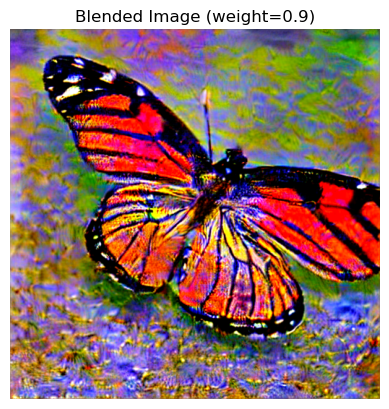

In [198]:

weight = 0.9 # Blend factor
modified_latents = apply_difference_matrix_to_latents(latent1, diff_latents, weight)

# Step 5: Decode the modified latents back into an image
modified_image = decode_latent_to_image(pipe, modified_latents)

# Visualize the generated image
plt.imshow(modified_image)
plt.title(f"Blended Image (weight={weight})")
plt.axis("off")
plt.show()

In [193]:
prompt_new = "a rabbit"

text_embedding_new = get_text_embedding(pipe, [prompt_new])

In [170]:
latent_new = get_latents_from_embedding(text_embedding_new)

/tmp/ipykernel_9275/654010051.py:26: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),


In [196]:
weight = 0.9
modified_latents = apply_difference_matrix_to_latents(latent_new, diff_latents, weight)

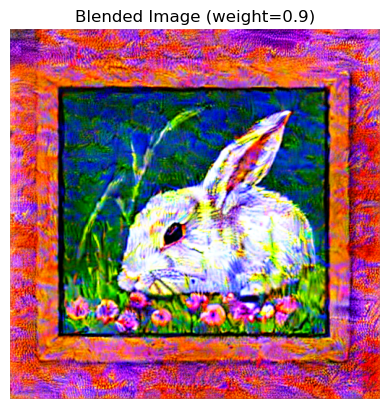

In [197]:
modified_image = decode_latent_to_image(pipe, modified_latents)

# Visualize the generated image
plt.imshow(modified_image)
plt.title(f"Blended Image (weight={weight})")
plt.axis("off")
plt.show()